# Parallelize Linear Regression with Stochastic gradient descent

 ## Strategy
1. When it is the root worker 
2. Load the file in the directory and store them in a dataframe 
3. Divide the data, given 70% to the train set and 30% to the test set
4. Divide the training set among the workers 
5. Initialize the first coefficients as zero 
6. Send slices of the training set(the features data X and the expected target data Y) to ever woker including the root worker 
7. or each epoch 
8. Every worker should get the predict target Y(yhat) for each slice
9. Get the new coefficient of each intance in a slice 
10. Gather the new coefficient from each worker 
11. Calculate the root mean square error for the test set 
12. Calculate the root mean square error for the test set 

In [ ]:

"""
Created on Tue May  8 18:39:03 2018
@author: John Robert
"""
import os
import sklearn
from sklearn.datasets import load_svmlight_file

from sklearn.metrics import mean_squared_error

import pandas as pd
import numpy as np
import math

from mpi4py import MPI                     
from decimal import Decimal, ROUND_HALF_UP

learning_rate = 0.001
number_of_instance = 200

sliced_features_X_train = []
sliced_expected_target_Y_train = []

x_data_for_worker = []
y_data_for_worker = []

#Multiply each coefficient with each feature to get the predict value of y
# yhat = b0 + b1 * x1 + b2 * x2 .....
def predicted_target_Y(features, coefficient):
    yhat_result = np.zeros(features.shape[0])
    
    for j in range(0, features.shape[1]):
        yhat_result += features[j]*coefficient[j]
    return pd.DataFrame(yhat_result)  

def estimating_new_coefficient(X, Y, predicted_Y, coefficient,learning_rate, number_of_instance = 200):
    for i in range(0,number_of_instance):
        #error = predicted value of Y - expected value of Y 
        error = (predicted_Y.iloc[i] - Y.iloc[i])
        #loop through each feature
        for j in range(0, X.shape[1]):
            
            
            #new coefficient  = old coefficient - learning_rate * error * X
            coefficient[j] = (coefficient[j] - (learning_rate * error * X.iloc[i][j]))
        #pred_Y = predictY(X, coef)
       # print(mean_squared_error(pred_Y, Y))
    return coefficient

def dividing_data(x_train, y_train, size_of_workers):
    #Divide the data among the workers
    slice_for_each_worker = int(Decimal(x_train.shape[0]/size_of_workers).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))      
    print('Slice of data for each worker: {}'.format(slice_for_each_worker))
    x_data_for_worker = []
    y_data_for_worker = []
    for i in range(0,size_of_workers):
        if i < size_of_workers - 1:
            x_data_for_worker.append(x_train[slice_for_each_worker*i:slice_for_each_worker*(i+1)])
            y_data_for_worker.append(y_train[slice_for_each_worker*i:slice_for_each_worker*(i+1)])
        else:
            x_data_for_worker.append(x_train[slice_for_each_worker*i:])
            y_data_for_worker.append(y_train[slice_for_each_worker*i:])
    return x_data_for_worker, y_data_for_worker


comm = MPI.COMM_WORLD                       # Initialize communicator
rank=comm.Get_rank()                        # ID of the cureent worker 
status = MPI.Status()                       # Rank ID of sender
size = comm.Get_size()                      # Number odf workers 
root = 0  
number_of_epochs = 10   




t_start = 0
t_diff = 0

if rank == root:
    t_start = MPI.Wtime()
    
    # Read data from the dataset    
    features_X = []
    expected_target_Y = []
    
    #Getting access to the path where we have the dataset
    path ="C:/Users/John Robert/Documents/Summer 2018/Distributed Data Analysis/Solutions/Exercise 4/Dataset_1/"
    files= os.listdir(path)
    os.chdir(path)
    
    # To read the data in the file one after the other then combine them as 1 
    for file in files:  
        x_axis, y_axis = load_svmlight_file(file)
        features_X.append(pd.DataFrame(x_axis.todense()))
        expected_target_Y.append(y_axis)
        
    #To clean the dataset by removing the nan values 
    features_X = pd.concat(features_X).fillna(0)
    
    #Normalizating to rescaling real valued numeric attributes into the range 0 and 1.
    features_X = pd.DataFrame(sklearn.preprocessing.normalize(features_X))
    expected_target_Y = pd.DataFrame(np.concatenate(np.array(expected_target_Y))) 

    # Divide the data into 70% train set and 30% test set 
    #Randomly pick 70% 0f the data 
    set_of_data = np.random.rand(len(features_X)) <= 0.7
    features_X_train = features_X[set_of_data]
    expected_target_Y_train = expected_target_Y[set_of_data]
    #the remaining 30% is for the test set
    features_X_test  = features_X[~set_of_data]
    expected_target_Y_test  = expected_target_Y[~set_of_data]
    
    #Divide the data among the workers
    slice_for_each_worker = int(Decimal(features_X_train.shape[0]/size).quantize(Decimal('1.'), rounding = ROUND_HALF_UP))      
    print('Slice of data for each worker: {}'.format(slice_for_each_worker))
    

    for i in range(0,size):
        if i < size - 1:
            x_data_for_worker.append(features_X_train[slice_for_each_worker*i:slice_for_each_worker*(i+1)])
            y_data_for_worker.append(features_X_train[slice_for_each_worker*i:slice_for_each_worker*(i+1)])
        
        #when it is the last process, give it the rest of the data 
        else:
            x_data_for_worker.append(features_X_train[slice_for_each_worker*i:])
            y_data_for_worker.append(expected_target_Y_train[slice_for_each_worker*i:])
    
  
    
else:
    
    slice_features_X_train = None
    slice_expected_target_Y_train = None
    
    wt = MPI.Wtime()

# Send the slice of data to work on to each worker    
sliced_features_X_train = comm.scatter(x_data_for_worker, root = root)
sliced_expected_target_Y_train = comm.scatter(y_data_for_worker, root = root)

#create the coefficient for linear regression 
coefficient_sliced_X = np.zeros(sliced_features_X_train.shape[1])

#print("coefficient_sliced_X \n {} \n".format(sliced_features_X_train.shape[1] +1))
for epoch in range(0, number_of_epochs):
    
   
    predicted_y_sliced = predicted_target_Y(sliced_features_X_train, coefficient_sliced_X)
    
    # estimating new coefficient
    new_coefficients =  estimating_new_coefficient(sliced_features_X_train, sliced_expected_target_Y_train, predicted_y_sliced, coefficient_sliced_X,learning_rate, number_of_instance = 200)
    
    # Gather the new coeffiecient for each slice of the training data
    gather_new_coefficients = pd.DataFrame(comm.gather(new_coefficients, root=0))

    comm.barrier()
  

    if rank == root:
        coef = gather_new_coefficients.mean()
        predicted_y = predicted_target_Y(features_X_test, coef)    
        print("Test set error(RMSE) for {} epoch is {}" .format(epoch+1, math.sqrt(mean_squared_error(expected_target_Y_test, predicted_y))))
        print("Train set error(RMSE) for {} epoch is {}" .format(epoch+1, math.sqrt(mean_squared_error(expected_target_Y_train, predicted_y_sliced))))
t_diff = MPI.Wtime() - t_start   
print('Process {}: {} secs.' .format(rank,t_diff))





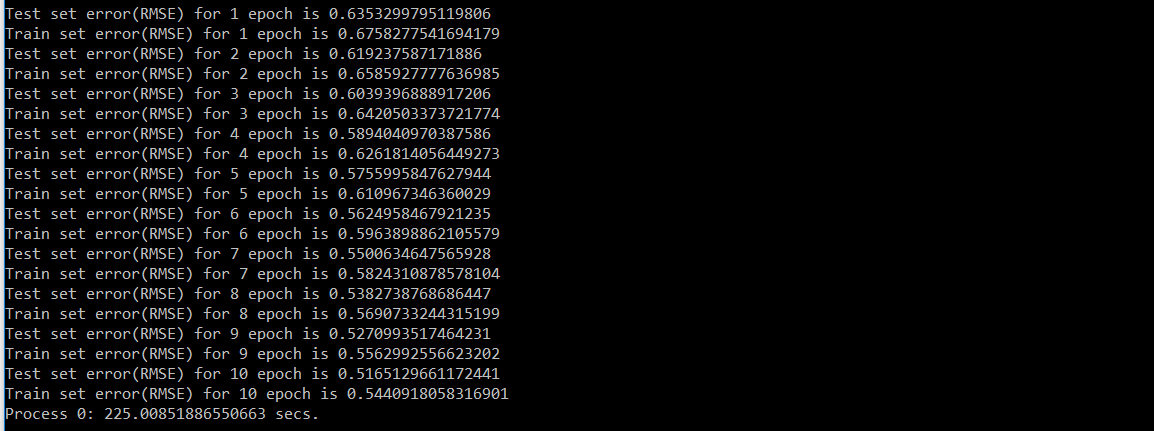

| Number of workers   | Number of epochs       |  Time taken | Test error  | Train error  |train/Test            |
|---------------------|------------------------|-------------|-------------|--------------|------------|
|     1               |         1              |    22.82    |0.6176       |0.6511        |1.0542      |
|     1               |         2              |    38.89    |0.5853       |0.6155        |1.0516      |                    
|     1               |         4              |    71.79    |0.5297       |0.5539        |1.0457      |                   
|     1               |         6              |    103.11   |0.4849       |0.5039        |1.0392      |
|     1               |         8              |    136.56   |0.4494       |0.4640        |1.0325      |
|     1               |        10              |    168.58   |0.4215       |0.4325        |1.0261      |
|     2               |         1              |    25.74    |0.6353       |0.6758        |1.0637      |
|     2               |         2              |    50.73    |0.6192       |0.6586        |1.0636      |
|     2               |         4              |    87.60    |0.5894       |0.6262        |1.0624      |
|     2               |         6              |    138.52   |0.5625       |0.5964        |1.0603      |
|     2               |         8              |    181.62   |0.5383       |0.5691        |1.0572      |                   |
|     2               |        10              |    241.42   |0.5165       |0.5441        |1.0534      |
|     4               |         1              |    46.88    |0.6370       |0.6825        |1.0714      |
|     4               |         2              |    94.16    |0.6227       |0.6666        |1.0704      |
|     4               |         4              |    160.36   |0.5949       |0.6367        |1.0702      |
|     4               |         6              |    230.80   |0.5710       |0.6091        |1.0667      |
|     4               |         8              |    309.42   |0.5501       |0.5836        |1.0609      |
|     4               |        10              |    376.1    |0.5317       |0.5610        |1.0551      |



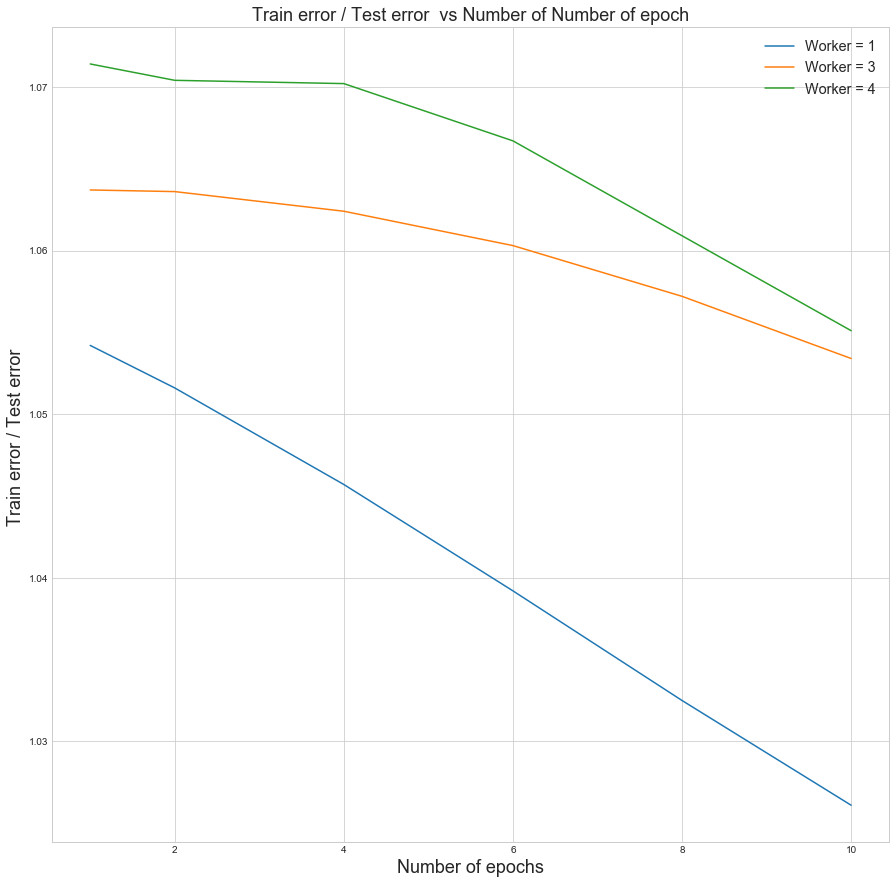

In [3]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (15,15)
sb.set_style ('whitegrid')

noEpochs  = [1,2,4,6,8,10]

worker1 = [1.0542 , 1.0516, 1.0457, 1.0392,1.0325, 1.0261]
worker2 = [1.0637 , 1.0636 , 1.0624 , 1.0603 ,1.0572,1.0534]
worker4 = [1.0714, 1.0704, 1.0702, 1.0667,1.0609,1.0551 ]
 
plt.plot(noEpochs,worker1, label = "Worker = 1" )
plt.plot(noEpochs,worker2, label = "Worker = 3" )
plt.plot(noEpochs,worker4, label = "Worker = 4" )


plt.xlabel("Number of epochs", fontsize=18)
plt.ylabel("Train error / Test error ", fontsize=18)
plt.yticks()
plt.title('Train error / Test error  vs Number of Number of epoch', fontsize=18)
plt.legend(fontsize='x-large')

## Comment
The error reduce as the number of epochs increases 

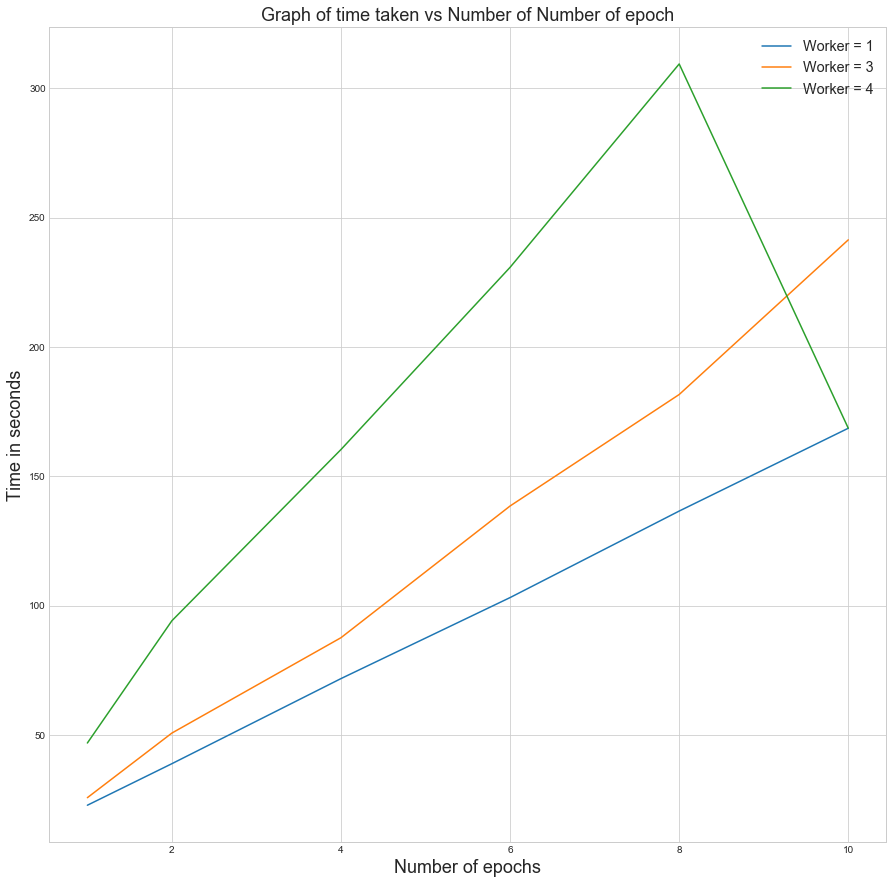

In [2]:
import numpy as np
import pandas as pd 
import matplotlib.pyplot as plt
from matplotlib import rcParams
import seaborn as sb

%matplotlib inline
plt.rcParams['figure.figsize'] = (15,15)
sb.set_style ('whitegrid')

noEpochs  = [1,2,4,6,8,10]

worker1 = [22.82, 38.89, 71.79, 103.11,136.56,168.58]
worker2 = [25.74, 50.73, 87.60, 138.52,181.62,241.42]
worker4 = [46.88, 94.16, 160.36, 230.80,309.42,168.58]
 
plt.plot(noEpochs,worker1, label = "Worker = 1" )
plt.plot(noEpochs,worker2, label = "Worker = 3" )
plt.plot(noEpochs,worker4, label = "Worker = 4" )


plt.xlabel("Number of epochs", fontsize=18)
plt.ylabel("Time in seconds", fontsize=18)
plt.yticks()
plt.title('Graph of time taken vs Number of Number of epoch', fontsize=18)
plt.legend(fontsize='x-large')

## Comment
As the number of workers increase the time taken for execution also increase, also as the number of epochs incease, the time taken for exection also increase